## Pablo Torre e Ignacio Jiménez

# Practical Assesment Task #1: Colorizing Images with Generative Adversarial Networks
Técnicas Generativas y Aprendizaje por Refuerzo - Curso 2023/2024



## Import Dependencies and Set General Parameters

In [1]:
# Import libraries
import os
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.layers import (
    Activation, MaxPooling2D, BatchNormalization, Conv2D, Dense, 
    Dropout, Flatten, LeakyReLU, UpSampling2D, concatenate, Input)
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from time import time
from skimage.color import rgb2lab, lab2rgb
from pathlib import Path
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential

# Enable memory growth for GPU
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Constants
IMAGE_SIZE = 32
EPOCHS = 100 # Increase or decrease as appropriate
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 100

WORKDIR = ""#/content/drive/My Drive/Colab Notebooks/Workspace/

# # Create directories
#Path(WORKDIR).mkdir(parents=True, exist_ok=True)
#Path(f"{WORKDIR}/results").mkdir(parents=True, exist_ok=True)

2024-03-05 17:58:50.217644: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-05 17:58:50.217683: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-05 17:58:50.218953: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-05 17:58:50.224750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 17:58:50.971669: W tensorflow/compiler/tf2

## Define Dataset Loader

In [2]:
def generate_dataset(images, debug=False):
    """
    This function converts a list of RGB images to the LAB color space, and separates the L channel from the A and B channels.
    The images are normalized and reshaped to the appropriate dimensions for the model.

    Parameters:
    images (list): A list of RGB images
    debug (bool): If True, the function will display the original and converted images

    Returns:
    X (np.array): A numpy array of L channels of the images
    Y (np.array): A numpy array of A and B channels of the images
    """
    X = []
    Y = []

    for i in images:
        lab_image_array = rgb2lab(i / 255)  # Convert the image from RGB to LAB color space
        x = lab_image_array[:, :, 0]  # Get the L channel
        y = lab_image_array[:, :, 1:]  # Get the A and B channels
        y /= 128  # normalize

        if debug:  # If debug is True, display the original and converted images
            fig = plt.figure()
            fig.add_subplot(1, 2, 1)
            plt.imshow(i / 255)

            fig.add_subplot(1, 2, 2)
            plt.imshow(lab2rgb(np.dstack((x, y * 128))))
            plt.show()

        X.append(x.reshape(IMAGE_SIZE, IMAGE_SIZE, 1))  # Reshape the L channel and append to the list
        Y.append(y)  # Append the A and B channels to the list

    X = np.array(X, dtype=np.float32)  # Convert the list to a numpy array
    Y = np.array(Y, dtype=np.float32)  # Convert the list to a numpy array

    return X, Y


def load_data(force=False):
    """
    This function loads the CIFAR-10 dataset, processes it, and saves/loads the processed data to/from the disk.

    Parameters:
    force (bool): If True, the function will reprocess the data even if it already exists on the disk

    Returns:
    X_train, Y_train, X_test, Y_test (np.array): Numpy arrays of the training and testing data
    """
    is_saved_arrays_exist = os.path.isfile(os.path.join(WORKDIR, 'X_train.npy'))  # Check if the processed data already exists on the disk

    if not is_saved_arrays_exist or force:  # If the processed data does not exist or if force is True, process the data
        (train_images, _), (test_images, _) = cifar10.load_data()  # Load the CIFAR-10 dataset
        X_train, Y_train = generate_dataset(train_images)  # Process the training images
        X_test, Y_test = generate_dataset(test_images)  # Process the testing images
        print('Saving processed data to Drive')
        np.save(os.path.join(WORKDIR, 'X_train.npy'), X_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'Y_train.npy'), Y_train)  # Save the processed training data to the disk
        np.save(os.path.join(WORKDIR, 'X_test.npy'), X_test)  # Save the processed testing data to the disk
        np.save(os.path.join(WORKDIR, 'Y_test.npy'), Y_test)  # Save the processed testing data to the disk
    else:  # If the processed data exists and force is False, load the data from the disk
        print('Loading processed data from Drive')
        X_train = np.load(os.path.join(WORKDIR, 'X_train.npy'))  # Load the processed training data from the disk
        Y_train = np.load(os.path.join(WORKDIR, 'Y_train.npy'))  # Load the processed training data from the disk
        X_test = np.load(os.path.join(WORKDIR, 'X_test.npy'))  # Load the processed testing data from the disk
        Y_test = np.load(os.path.join(WORKDIR, 'Y_test.npy'))  # Load the processed testing data from the disk

    return X_train, Y_train, X_test, Y_test

## Load Dataset

In [3]:
# Load the processed training and testing data
X_train, Y_train, X_test, Y_test = load_data()

# Create TensorFlow datasets from the training and testing data
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

# Shuffle the training dataset and batch both datasets
# SHUFFLE_BUFFER_SIZE determines the randomness of the shuffling
# BATCH_SIZE determines the number of samples that will be propagated through the network at once
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Loading processed data from Drive


2024-03-05 17:58:52.395474: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 17:58:52.439766: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 17:58:52.440067: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Define Generator Model

In [4]:
def build_generator_model():
    """
    This function builds the generator model for the GAN. The generator is responsible for generating new, fake images.
    It uses a series of Conv2D, BatchNormalization, and UpSampling2D layers.

    Returns:
    model (Sequential): The generator model
    """
    model = Sequential()  # Initialize the model

    # COMPLETE

    # Suggested architecture:
    # Downsampling
        # Add a series of Conv2D layers followed by BatchNormalization layers
        # Conv2D layers are used for the convolution operation that extracts features from the input images
        # Conv2D layers with stride=1 preserve the dimensions of the image
        # Conv2D layers with stride=2 downsample the image (i.e., reduce the dimensions of the image by half)
        # BatchNormalization layers are used to normalize the activations of the previous layer at each batch
        # ReLU activation function is used to add non-linearity to the output of the previous layer
        # Padding is set to 'same' to preserve the dimensions of the image
        # Repeat this series of layers N times
    
    model = tf.keras.Sequential()

    model.add(Conv2D(64, (3, 3), strides=2, input_shape = (32, 32,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(64, (3, 3), strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(128, (3, 3), strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(196, (3, 3), strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2D(256, (3, 3), strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    # Upsampling
        # UpSampling2D layer is used to increase the dimension of the image
        # Add as many UpSampling2D layers as Conv2D layers with stride=2 to upsample the image to its original dimensions
        # Add a series of Conv2D layers followed by BatchNormalization layers
        # BatchNormalization layers are used to normalize the activations of the previous layer at each batch
        # ReLU activation function is used to add non-linearity to the output of the previous layer
    
    model.add(UpSampling2D((2, 2), interpolation='lanczos3'))
    model.add(Conv2D(196, (3, 3), strides=1, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(UpSampling2D((2, 2), interpolation='lanczos3'))
    model.add(Conv2D(128, (3, 3), strides=1, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D((2, 2), interpolation='lanczos3'))
    model.add(Conv2D(64, (3, 3), strides=1, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(UpSampling2D((2, 2), interpolation='lanczos3'))
    model.add(Conv2D(32, (3, 3), strides=1, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    # Output layer
        # Add a Conv2D layer with 2 filters to output the A and B LAB channels of the image
        # Activation layer is used to apply the tanh activation function to the output
        # tanh activation function is used because the pixels of the output images range from -1 to 1
    
    model.add(UpSampling2D((2, 2), interpolation='lanczos3'))
    model.add(Conv2D(2, (3, 3), strides=1, padding='same', use_bias=True, activation='tanh'))


    return model

In [5]:
generator = build_generator_model()
generator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        576       
                                                                 
 batch_normalization (Batch  (None, 16, 16, 64)        256       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          36864     
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 64)          256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 64)         

## Define Discriminator Model

In [6]:
def build_discriminator_model():
    """
    This function builds the discriminator model for the GAN. The discriminator is responsible for distinguishing real images from fake ones.
    It is recommended to use a series of Conv2D, Dropout, AveragePooling2D, Flatten, Dense, LeakyReLU, BatchNormalization, and Activation layers to create the model.

    Returns:
    model (Sequential): The discriminator model
    """
    
    model = Sequential()  # Initialize the model
    
    # COMPLETE
    
    # Suggested architecture:
    # Convolution blocks
        # Add a series of Conv2D layers followed by Dropout
        # Conv2D layers are used for the convolution operation that extracts features from the input images
        # Dropout layers are used to prevent overfitting by randomly setting a fraction rate of input units to 0 at each update during training time
        # Repeat this series of layers N times
    
    model.add(Conv2D(24, (3, 3), strides=2, input_shape = (32, 32, 3), padding='same'))
    model.add(LeakyReLU())

    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model.add(Conv2D(16, (3, 3), strides=2, padding='same', use_bias=False))    
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'))

    model.add(Conv2D(16, (3, 3), strides=2, padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Flatten())

    # Dense layers
    model.add(Dense(48, use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(1, activation='sigmoid'))


    # Pooling and dense layers
        # AveragePooling2D layer is used to downscale the image spatially
        # Flatten layer is used to convert the 2D matrix of features into a vector that can be fed into a fully connected neural network classifier
        # Dense layers are the regular deeply connected neural network layers
        # LeakyReLU is a type of activation function that allows a small gradient when the unit is not active
        # BatchNormalization layers are used to normalize the activations of the previous layer at each batch
        # Dropout layers are used to prevent overfitting by randomly setting a fraction rate of input units to 0 at each update during training time
    
    # Output layer
        # Add a Dense layer with 1 unit to output the probability of the input image being real or synthetic
        # Activation layer is used to apply the sigmoid activation function to the output
        # sigmoid activation function is used because the output is a probability between 0 and 1
    
    
    
    return model

In [7]:
discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 16, 16, 24)        672       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 24)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 8, 24)          0         
 D)                                                              
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 16)          3456      
                                                                 
 batch_normalization_9 (Bat  (None, 4, 4, 16)          64        
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 4, 4, 16)         

## Define Generator and Discriminator Loss Functions

In [8]:
# Define the weight of the GAN loss
gan_loss_weight = 1

# Define the regularization parameter for the generator's L2 loss
l2_lambda = 150

# Define the loss function for the discriminator
# Binary Cross Entropy is used as the loss function since we are dealing with a binary classification problem (real vs fake images)
cross_entropy = tf.keras.losses.BinaryCrossentropy() 

def discriminator_loss(disc_real_output, disc_generated_output):
    """
    This function calculates the total loss for the discriminator.

    Parameters:
    disc_real_output (Tensor): The discriminator's prediction on the real images
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images

    Returns:
    total_disc_loss (Tensor): The total loss for the discriminator
    """
    
    total_disc_loss = 0  # Initialize the total loss for the discriminator
    
    # Calculate the cross entropy loss for the real images
    # COMPLETE
    real_loss = cross_entropy(tf.ones_like(disc_real_output), disc_real_output)

    
    # Calculate the cross entropy loss for the generated (synthetic) images
    # COMPLETE
    generated_loss = cross_entropy(tf.zeros_like(disc_generated_output), disc_generated_output)

    # Calculate the total loss for the discriminator by adding the losses for the real and generated images
    # COMPLETE
    total_disc_loss = real_loss + generated_loss
    
    # Return the total loss for the discriminator
    return total_disc_loss


def generator_loss(disc_generated_output, gen_output, target):
    """
    This function calculates the total loss for the generator.

    Parameters:
    disc_generated_output (Tensor): The discriminator's prediction on the generated (fake) images
    gen_output (Tensor): The generated (fake) images
    target (Tensor): The real images

    Returns:
    total_gen_loss (Tensor): The total loss for the generator
    gan_loss (Tensor): The GAN loss for the generator
    l2_loss (Tensor): The L2 loss for the generator
    """
    
    total_gen_loss = 0  # Initialize the total loss for the generator
    gan_loss = 0  # Initialize the GAN loss for the generator
    l2_loss = 0  # Initialize the L2 loss for the generator
    
    # Calculate the GAN loss for the generator (i.e., the loss for fooling the discriminator)
    # COMPLETE
    gan_loss = cross_entropy(tf.ones_like(disc_generated_output), disc_generated_output)

    # Calculate the L2 loss for the generator by comparing the generated images to the real images
    # COMPLETE
    l2_loss = tf.reduce_mean(tf.square(target - gen_output))
    
    # Calculate the total loss for the generator by adding the GAN loss (multiplied by its corresponding weight) and the L2 loss (multiplied by the regularization parameter)
    # COMPLETE
    total_gen_loss = gan_loss_weight * gan_loss + l2_lambda * l2_loss
    
    # Return the total loss, GAN loss, and L2 loss for the generator
    return total_gen_loss, gan_loss, l2_loss



## Build Generator and Discriminator Models

In [9]:
# Instantiate the generator and discriminator models
generator = build_generator_model()
discriminator = build_discriminator_model()

# Print out the model summaries
generator.summary()
discriminator.summary()

# Define the optimizers for the generator and discriminator
# Adam optimizer is used with a learning rate of 2e-4 and beta_1 (the exponential decay rate for the first moment estimates) of 0.5
# It is recommended to experiment with different values for the learning rate. Beta_1 value of 0.5 is recommended for GANs
# It is possible that the optimal learning rate for the generator and discriminator is different from each other
gen_learning_rate = 2e-3
gene_beta_1 = 0.5

disc_learning_rate = 2e-3
disc_beta_1 = 0.5

generator_optimizer = tf.keras.optimizers.Adam(gen_learning_rate, beta_1=gene_beta_1)
discriminator_optimizer = tf.keras.optimizers.Adam(disc_learning_rate, beta_1=disc_beta_1)

# Define the directory for storing the training checkpoints
checkpoint_dir = os.path.join(WORKDIR, 'training-checkpoints')
# Define the prefix for the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Create a checkpoint object which will be used to save and load the models and optimizers
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)
# Create a manager for the checkpoint object, which will be responsible for saving and loading the checkpoints
# max_to_keep parameter is set to 3, meaning that only the 3 most recent checkpoints will be kept
manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=3)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        576       
                                                                 
 batch_normalization_12 (Ba  (None, 16, 16, 64)        256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 64)          36864     
                                                                 
 batch_normalization_13 (Ba  (None, 8, 8, 64)          256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 8, 8, 64)         

In [10]:
# Define the directory and file for storing the TensorBoard summary logs
summary_log_file = os.path.join(
    WORKDIR, 'tf-summary', datetime.now().strftime("%Y%m%d-%H%M%S"))
# Create a summary writer for writing the summary logs
summary_writer = tf.summary.create_file_writer(summary_log_file)

@tf.function
def train_step(input_image, target, epoch):
    """
    This function performs one training step for the generator and discriminator.

    Parameters:
    input_image (Tensor): The input image
    target (Tensor): The target image
    epoch (int): The current epoch number

    Returns:
    gen_total_loss (Tensor): The total loss for the generator
    disc_loss (Tensor): The loss for the discriminator
    """
    
    # Open a GradientTape context for automatic differentiation
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_total_loss = 0  # Initialize the total loss for the generator
        gen_gan_loss = 0  # Initialize the GAN loss for the generator
        gen_l2_loss = 0  # Initialize the L2 loss for the generator
        disc_loss = 0  # Initialize the loss for the discriminator
        
        # Generate an image using the generator
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        # COMPLETE
        gen_output = generator(input_image, training=True)
        gen_output = tf.keras.layers.Concatenate(axis=3)([gen_output, input_image])
        # Get the discriminator's predictions on the real and generated images
        # (remember to set training=True, since during training time BatchNormalization layers are applied using the batch mean and variance)
        # COMPLETE
        target = tf.keras.layers.Concatenate(axis=3)([target, input_image])
        input_disc = tf.keras.layers.Concatenate(axis=0)([target, gen_output])

        # concatenate black and white with color
        out_disc = discriminator(input_disc, training=True)
        disc_real_output, disc_generated_output = out_disc[:BATCH_SIZE], out_disc[BATCH_SIZE:]
        

        # Calculate the losses for the generator and discriminator
        # COMPLETE
        gen_total_loss, gen_gan_loss, gen_l2_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Calculate the gradients of the generator's and discriminator's losses with respect to the trainable variables of each model
    # Use the gradient() method of the GradientTape object of each model to calculate the gradients of the losses with respect to the trainable variables of the corresponding model
    # Model's trainable variables can be accessed using the trainable_variables attribute
    # COMPLETE
    generator_gradients = gen_tape.gradient(gen_total_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


    # Apply the gradients to the model's trainable variables
    # Use the apply_gradients() method of the optimizer object to apply the gradients
    # The apply_gradients() method takes a list of (gradient, variable) pairs
    # zip() function can be used to iterate over two lists simultaneously (i.e., the gradients and the model's trainable variables)
    # COMPLETE
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    # Write the losses to the summary logs
    with summary_writer.as_default():
        tf.summary.scalar('gen_total_loss', gen_total_loss, step=epoch)
        tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=epoch)
        tf.summary.scalar('gen_l2_loss', gen_l2_loss, step=epoch)
        tf.summary.scalar('disc_loss', disc_loss, step=epoch)

    return gen_total_loss, disc_loss

In [11]:
# The checkpoint manager will load the latest checkpoint if it exists
# This will be used to resume training if the training process was interrupted
# If no checkpoint exists, the models will be initialized from scratch

# Restore the latest checkpoint using the checkpoint manager
checkpoint.restore(manager.latest_checkpoint)

# If a checkpoint was found and restored, print a message indicating the checkpoint file
if manager.latest_checkpoint:
    print('Restored from {}'.format(manager.latest_checkpoint))
    
# If no checkpoint was found, print a message indicating that the models are being initialized from scratch
else:
    print('Initializing from scratch')

Initializing from scratch


In [12]:
# Loop over the epochs
for e in tqdm(range(EPOCHS)):
    # Record the start time of the epoch
    start_time = time()
    
    gen_loss_total = 0  # Initialize the total loss for the generator
    disc_loss_total = 0  # Initialize the total loss for the discriminator
    
    # Loop over the training dataset
    # COMPLETE
    for input_image, target in train_dataset:
        # Perform one training step and get the generator and discriminator losses
        # COMPLETE
        gen_loss, disc_loss = train_step(input_image, target, e)

        # Add the losses to the total losses
        # COMPLETE
        gen_loss_total += gen_loss
        disc_loss_total += disc_loss
        
    # Calculate the time taken for the epoch
    time_taken = time() - start_time

    # If the epoch number is a multiple of 10, save a checkpoint
    #if (e + 1) % 10 == 0:
        #checkpoint.save(file_prefix=checkpoint_prefix)

    # Print the epoch number, average generator loss, average discriminator loss, and time taken
    # print('Epoch {}: gen loss: {}, disc loss: {}, time: {:.2f}s'.format(
    #     e + 1, gen_loss_total / BATCH_SIZE, disc_loss_total / BATCH_SIZE, time_taken))
    print(f'Epoch {e + 1}: gen loss: {gen_loss_total / (BATCH_SIZE*len(train_dataset))}, disc loss: {disc_loss_total / (BATCH_SIZE*len(train_dataset))}, time: {time_taken:.2f}s')

  0%|          | 0/100 [00:00<?, ?it/s]2024-03-05 17:58:57.877419: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-03-05 17:58:57.986990: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-05 17:58:59.523042: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-05 17:59:01.449099: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f923acc3c30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-05 17:59:01.449121: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-03-05 17:59:01.454003: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:170

Epoch 1: gen loss: 0.017563574016094208, disc loss: 0.010870594531297684, time: 40.09s


  2%|▏         | 2/100 [01:05<51:26, 31.50s/it]  

Epoch 2: gen loss: 0.0148288169875741, disc loss: 0.010833602398633957, time: 25.48s


  3%|▎         | 3/100 [01:31<46:32, 28.79s/it]

Epoch 3: gen loss: 0.014102518558502197, disc loss: 0.010831819847226143, time: 25.55s


  4%|▍         | 4/100 [01:56<44:10, 27.61s/it]

Epoch 4: gen loss: 0.01413479633629322, disc loss: 0.010831615887582302, time: 25.80s


  5%|▌         | 5/100 [02:22<42:34, 26.89s/it]

Epoch 5: gen loss: 0.013884450308978558, disc loss: 0.010832424275577068, time: 25.61s


  6%|▌         | 6/100 [02:48<41:34, 26.54s/it]

Epoch 6: gen loss: 0.013590161688625813, disc loss: 0.010831049643456936, time: 25.85s


  7%|▋         | 7/100 [03:15<41:32, 26.80s/it]

Epoch 7: gen loss: 0.013354805298149586, disc loss: 0.010831514373421669, time: 27.34s


  8%|▊         | 8/100 [03:41<40:39, 26.52s/it]

Epoch 8: gen loss: 0.012892131693661213, disc loss: 0.010830768384039402, time: 25.90s


  9%|▉         | 9/100 [04:07<39:46, 26.23s/it]

Epoch 9: gen loss: 0.012803787365555763, disc loss: 0.010831203311681747, time: 25.58s


 10%|█         | 10/100 [04:32<39:04, 26.05s/it]

Epoch 10: gen loss: 0.012745056301355362, disc loss: 0.010831864550709724, time: 25.65s


 11%|█         | 11/100 [05:00<39:33, 26.67s/it]

Epoch 11: gen loss: 0.013854730874300003, disc loss: 0.010272868908941746, time: 28.06s


 12%|█▏        | 12/100 [05:27<39:16, 26.77s/it]

Epoch 12: gen loss: 0.01490920688956976, disc loss: 0.009662538766860962, time: 27.01s


 13%|█▎        | 13/100 [05:53<38:14, 26.38s/it]

Epoch 13: gen loss: 0.01582704298198223, disc loss: 0.009108196012675762, time: 25.46s


 14%|█▍        | 14/100 [06:19<37:33, 26.20s/it]

Epoch 14: gen loss: 0.01620130054652691, disc loss: 0.008893976919353008, time: 25.79s


 15%|█▌        | 15/100 [06:44<36:55, 26.06s/it]

Epoch 15: gen loss: 0.016241787001490593, disc loss: 0.008800324983894825, time: 25.73s


 16%|█▌        | 16/100 [07:12<36:57, 26.40s/it]

Epoch 16: gen loss: 0.016446661204099655, disc loss: 0.008608297444880009, time: 27.17s


 17%|█▋        | 17/100 [07:40<37:09, 26.86s/it]

Epoch 17: gen loss: 0.016728786751627922, disc loss: 0.008389856666326523, time: 27.94s


 18%|█▊        | 18/100 [08:07<36:55, 27.02s/it]

Epoch 18: gen loss: 0.016867058351635933, disc loss: 0.008272388949990273, time: 27.36s


 19%|█▉        | 19/100 [08:33<36:10, 26.80s/it]

Epoch 19: gen loss: 0.0169225987046957, disc loss: 0.008181978948414326, time: 26.28s


 20%|██        | 20/100 [09:00<35:30, 26.63s/it]

Epoch 20: gen loss: 0.01698664389550686, disc loss: 0.00808684341609478, time: 26.23s


 21%|██        | 21/100 [09:26<34:53, 26.50s/it]

Epoch 21: gen loss: 0.016953177750110626, disc loss: 0.008033974096179008, time: 26.19s


 22%|██▏       | 22/100 [09:52<34:21, 26.42s/it]

Epoch 22: gen loss: 0.016778623685240746, disc loss: 0.008063715882599354, time: 26.25s


 23%|██▎       | 23/100 [10:18<33:49, 26.36s/it]

Epoch 23: gen loss: 0.016772430390119553, disc loss: 0.007995168678462505, time: 26.19s


 24%|██▍       | 24/100 [10:44<33:19, 26.30s/it]

Epoch 24: gen loss: 0.016651557758450508, disc loss: 0.008017740212380886, time: 26.17s


 25%|██▌       | 25/100 [11:10<32:47, 26.23s/it]

Epoch 25: gen loss: 0.016588948667049408, disc loss: 0.007972832769155502, time: 26.06s


 26%|██▌       | 26/100 [11:37<32:21, 26.24s/it]

Epoch 26: gen loss: 0.016540449112653732, disc loss: 0.007937503047287464, time: 26.24s


 27%|██▋       | 27/100 [12:03<31:54, 26.23s/it]

Epoch 27: gen loss: 0.016515055671334267, disc loss: 0.007892342284321785, time: 26.21s


 28%|██▊       | 28/100 [12:29<31:35, 26.33s/it]

Epoch 28: gen loss: 0.016428204253315926, disc loss: 0.007898004725575447, time: 26.55s


 29%|██▉       | 29/100 [12:56<31:08, 26.31s/it]

Epoch 29: gen loss: 0.016340678557753563, disc loss: 0.007916834205389023, time: 26.26s


 30%|███       | 30/100 [13:22<30:42, 26.32s/it]

Epoch 30: gen loss: 0.016197238117456436, disc loss: 0.007919454015791416, time: 26.33s


 31%|███       | 31/100 [13:48<30:15, 26.31s/it]

Epoch 31: gen loss: 0.016125982627272606, disc loss: 0.007908985950052738, time: 26.27s


 32%|███▏      | 32/100 [14:14<29:46, 26.27s/it]

Epoch 32: gen loss: 0.01596745476126671, disc loss: 0.007948900572955608, time: 26.19s


 33%|███▎      | 33/100 [14:41<29:19, 26.27s/it]

Epoch 33: gen loss: 0.01577107235789299, disc loss: 0.007993778213858604, time: 26.25s


 34%|███▍      | 34/100 [15:07<28:51, 26.24s/it]

Epoch 34: gen loss: 0.015698717907071114, disc loss: 0.007967648096382618, time: 26.16s


 35%|███▌      | 35/100 [15:33<28:26, 26.25s/it]

Epoch 35: gen loss: 0.015694085508584976, disc loss: 0.007946125231683254, time: 26.28s


 36%|███▌      | 36/100 [15:59<27:59, 26.24s/it]

Epoch 36: gen loss: 0.015567191876471043, disc loss: 0.008003458380699158, time: 26.20s


 37%|███▋      | 37/100 [16:26<27:33, 26.24s/it]

Epoch 37: gen loss: 0.015448368154466152, disc loss: 0.007993819192051888, time: 26.26s


 38%|███▊      | 38/100 [16:52<27:05, 26.21s/it]

Epoch 38: gen loss: 0.015414026565849781, disc loss: 0.008017854765057564, time: 26.13s


 39%|███▉      | 39/100 [17:18<26:41, 26.26s/it]

Epoch 39: gen loss: 0.015244675800204277, disc loss: 0.008077815175056458, time: 26.36s


 40%|████      | 40/100 [17:45<26:19, 26.33s/it]

Epoch 40: gen loss: 0.015253216959536076, disc loss: 0.00801131408661604, time: 26.50s


 41%|████      | 41/100 [18:11<25:51, 26.29s/it]

Epoch 41: gen loss: 0.015171520411968231, disc loss: 0.008055847138166428, time: 26.19s


 42%|████▏     | 42/100 [18:37<25:24, 26.28s/it]

Epoch 42: gen loss: 0.015051967464387417, disc loss: 0.008078575134277344, time: 26.26s


 43%|████▎     | 43/100 [19:03<24:56, 26.25s/it]

Epoch 43: gen loss: 0.014960612170398235, disc loss: 0.008109497837722301, time: 26.18s


 44%|████▍     | 44/100 [19:30<24:29, 26.25s/it]

Epoch 44: gen loss: 0.014896990731358528, disc loss: 0.008094065822660923, time: 26.23s


 45%|████▌     | 45/100 [19:56<24:04, 26.27s/it]

Epoch 45: gen loss: 0.014792941510677338, disc loss: 0.008115488104522228, time: 26.30s


 46%|████▌     | 46/100 [20:22<23:39, 26.29s/it]

Epoch 46: gen loss: 0.014712873846292496, disc loss: 0.008155387826263905, time: 26.35s


 47%|████▋     | 47/100 [20:48<23:12, 26.27s/it]

Epoch 47: gen loss: 0.014534283429384232, disc loss: 0.008223784156143665, time: 26.21s


 48%|████▊     | 48/100 [21:15<22:45, 26.26s/it]

Epoch 48: gen loss: 0.014485945925116539, disc loss: 0.008210423402488232, time: 26.24s


 49%|████▉     | 49/100 [21:41<22:17, 26.23s/it]

Epoch 49: gen loss: 0.014371642842888832, disc loss: 0.008280576206743717, time: 26.17s


 50%|█████     | 50/100 [22:07<21:52, 26.26s/it]

Epoch 50: gen loss: 0.014302349649369717, disc loss: 0.00827165599912405, time: 26.30s


 51%|█████     | 51/100 [22:34<21:28, 26.30s/it]

Epoch 51: gen loss: 0.01427805982530117, disc loss: 0.008242915384471416, time: 26.39s


 52%|█████▏    | 52/100 [23:00<21:02, 26.31s/it]

Epoch 52: gen loss: 0.01418779231607914, disc loss: 0.00828404352068901, time: 26.34s


 53%|█████▎    | 53/100 [23:26<20:36, 26.32s/it]

Epoch 53: gen loss: 0.014194215647876263, disc loss: 0.008262386545538902, time: 26.32s


 54%|█████▍    | 54/100 [23:53<20:17, 26.47s/it]

Epoch 54: gen loss: 0.014139601960778236, disc loss: 0.008282739669084549, time: 26.83s


 55%|█████▌    | 55/100 [24:19<19:47, 26.38s/it]

Epoch 55: gen loss: 0.014118991792201996, disc loss: 0.008259143680334091, time: 26.17s


 56%|█████▌    | 56/100 [24:46<19:20, 26.37s/it]

Epoch 56: gen loss: 0.01409288588911295, disc loss: 0.008262871764600277, time: 26.32s


 57%|█████▋    | 57/100 [25:12<18:53, 26.37s/it]

Epoch 57: gen loss: 0.014010153710842133, disc loss: 0.008292303420603275, time: 26.38s


 58%|█████▊    | 58/100 [25:38<18:25, 26.33s/it]

Epoch 58: gen loss: 0.01397705078125, disc loss: 0.008274395950138569, time: 26.22s


 59%|█████▉    | 59/100 [26:04<17:58, 26.29s/it]

Epoch 59: gen loss: 0.013928721658885479, disc loss: 0.008311962708830833, time: 26.20s


 60%|██████    | 60/100 [26:31<17:34, 26.36s/it]

Epoch 60: gen loss: 0.013884356245398521, disc loss: 0.008294174447655678, time: 26.51s


 61%|██████    | 61/100 [26:57<17:08, 26.37s/it]

Epoch 61: gen loss: 0.013816987164318562, disc loss: 0.008332427591085434, time: 26.37s


 62%|██████▏   | 62/100 [27:24<16:42, 26.39s/it]

Epoch 62: gen loss: 0.01386350393295288, disc loss: 0.008289697580039501, time: 26.43s


 63%|██████▎   | 63/100 [27:50<16:16, 26.39s/it]

Epoch 63: gen loss: 0.01376387383788824, disc loss: 0.008314447477459908, time: 26.40s


 64%|██████▍   | 64/100 [28:16<15:47, 26.33s/it]

Epoch 64: gen loss: 0.013661584816873074, disc loss: 0.008359966799616814, time: 26.17s


 65%|██████▌   | 65/100 [28:42<15:20, 26.29s/it]

Epoch 65: gen loss: 0.013720032759010792, disc loss: 0.008309582248330116, time: 26.21s


 66%|██████▌   | 66/100 [29:09<14:53, 26.29s/it]

Epoch 66: gen loss: 0.013597347773611546, disc loss: 0.008363649249076843, time: 26.27s


 67%|██████▋   | 67/100 [29:35<14:27, 26.29s/it]

Epoch 67: gen loss: 0.013622166588902473, disc loss: 0.008336002007126808, time: 26.29s


 68%|██████▊   | 68/100 [30:02<14:03, 26.36s/it]

Epoch 68: gen loss: 0.013568663969635963, disc loss: 0.00836981926113367, time: 26.53s


 69%|██████▉   | 69/100 [30:28<13:36, 26.35s/it]

Epoch 69: gen loss: 0.013428140431642532, disc loss: 0.008435064926743507, time: 26.32s


 70%|███████   | 70/100 [30:55<13:15, 26.51s/it]

Epoch 70: gen loss: 0.013453522697091103, disc loss: 0.008379208855330944, time: 26.86s


 71%|███████   | 71/100 [31:22<12:55, 26.73s/it]

Epoch 71: gen loss: 0.013449265621602535, disc loss: 0.008392618037760258, time: 27.25s


 72%|███████▏  | 72/100 [31:49<12:26, 26.66s/it]

Epoch 72: gen loss: 0.01334456354379654, disc loss: 0.008415257558226585, time: 26.48s


 73%|███████▎  | 73/100 [32:15<11:57, 26.57s/it]

Epoch 73: gen loss: 0.013373934663832188, disc loss: 0.008411292918026447, time: 26.37s


 74%|███████▍  | 74/100 [32:42<11:32, 26.63s/it]

Epoch 74: gen loss: 0.01333770714700222, disc loss: 0.008421871811151505, time: 26.76s


 75%|███████▌  | 75/100 [33:08<11:05, 26.62s/it]

Epoch 75: gen loss: 0.01325535960495472, disc loss: 0.008430451154708862, time: 26.60s


 76%|███████▌  | 76/100 [33:35<10:39, 26.63s/it]

Epoch 76: gen loss: 0.01322210393846035, disc loss: 0.008457939140498638, time: 26.65s


 77%|███████▋  | 77/100 [34:03<10:23, 27.11s/it]

Epoch 77: gen loss: 0.01323411613702774, disc loss: 0.008451191708445549, time: 28.20s


 78%|███████▊  | 78/100 [34:31<10:01, 27.35s/it]

Epoch 78: gen loss: 0.01326801348477602, disc loss: 0.008426099084317684, time: 27.90s


 79%|███████▉  | 79/100 [34:58<09:29, 27.11s/it]

Epoch 79: gen loss: 0.013155641034245491, disc loss: 0.008462997153401375, time: 26.56s


 80%|████████  | 80/100 [35:24<08:59, 26.98s/it]

Epoch 80: gen loss: 0.013194995932281017, disc loss: 0.00842240359634161, time: 26.65s


 81%|████████  | 81/100 [35:51<08:31, 26.91s/it]

Epoch 81: gen loss: 0.013123638927936554, disc loss: 0.008457817137241364, time: 26.75s


 82%|████████▏ | 82/100 [36:18<08:02, 26.82s/it]

Epoch 82: gen loss: 0.013097088783979416, disc loss: 0.008465232327580452, time: 26.61s


 83%|████████▎ | 83/100 [36:44<07:34, 26.76s/it]

Epoch 83: gen loss: 0.013035100884735584, disc loss: 0.008506053127348423, time: 26.62s


 84%|████████▍ | 84/100 [37:11<07:07, 26.74s/it]

Epoch 84: gen loss: 0.013137293979525566, disc loss: 0.00842199381440878, time: 26.69s


 85%|████████▌ | 85/100 [37:38<06:41, 26.75s/it]

Epoch 85: gen loss: 0.013074614107608795, disc loss: 0.008463425561785698, time: 26.75s


 86%|████████▌ | 86/100 [38:05<06:16, 26.88s/it]

Epoch 86: gen loss: 0.013071983121335506, disc loss: 0.00844581238925457, time: 27.19s


 87%|████████▋ | 87/100 [38:32<05:48, 26.80s/it]

Epoch 87: gen loss: 0.012966214679181576, disc loss: 0.00849270448088646, time: 26.60s


 88%|████████▊ | 88/100 [38:58<05:20, 26.74s/it]

Epoch 88: gen loss: 0.01299426518380642, disc loss: 0.00843661930412054, time: 26.59s


 89%|████████▉ | 89/100 [39:25<04:54, 26.77s/it]

Epoch 89: gen loss: 0.01294652372598648, disc loss: 0.008470211178064346, time: 26.84s


 90%|█████████ | 90/100 [39:52<04:27, 26.75s/it]

Epoch 90: gen loss: 0.012842059135437012, disc loss: 0.008521675132215023, time: 26.69s


 91%|█████████ | 91/100 [40:18<03:59, 26.66s/it]

Epoch 91: gen loss: 0.012845083139836788, disc loss: 0.008509675040841103, time: 26.46s


 92%|█████████▏| 92/100 [40:45<03:34, 26.85s/it]

Epoch 92: gen loss: 0.012820368632674217, disc loss: 0.008500365540385246, time: 27.29s


 93%|█████████▎| 93/100 [41:12<03:07, 26.85s/it]

Epoch 93: gen loss: 0.012860951945185661, disc loss: 0.008483530953526497, time: 26.85s


 94%|█████████▍| 94/100 [41:39<02:41, 26.84s/it]

Epoch 94: gen loss: 0.01282029040157795, disc loss: 0.008501806296408176, time: 26.80s


 95%|█████████▌| 95/100 [42:06<02:13, 26.79s/it]

Epoch 95: gen loss: 0.012831998988986015, disc loss: 0.008481255732476711, time: 26.65s


 96%|█████████▌| 96/100 [42:34<01:48, 27.09s/it]

Epoch 96: gen loss: 0.012708990834653378, disc loss: 0.00856249500066042, time: 27.80s


 97%|█████████▋| 97/100 [43:01<01:21, 27.29s/it]

Epoch 97: gen loss: 0.012765024788677692, disc loss: 0.008488249965012074, time: 27.75s


 98%|█████████▊| 98/100 [43:28<00:54, 27.22s/it]

Epoch 98: gen loss: 0.012728056870400906, disc loss: 0.008506499230861664, time: 27.03s


 99%|█████████▉| 99/100 [43:55<00:27, 27.06s/it]

Epoch 99: gen loss: 0.012808454222977161, disc loss: 0.008465619757771492, time: 26.68s


100%|██████████| 100/100 [44:23<00:00, 26.63s/it]

Epoch 100: gen loss: 0.012782257981598377, disc loss: 0.008463369682431221, time: 27.44s


In [13]:
# tensorboard
%tensorboard 

UsageError: Line magic function `%tensorboard` not found.


## Plot Results

150 / 150

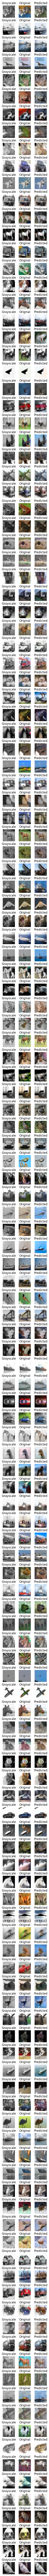

In [14]:
# Define the number of samples to generate
n_samples = 150
# Generate colorized versions of the first n_samples grayscale images in the test set
Y_hat = generator(X_test[:n_samples], training=False)

# Define the number of rows in the grid, which is equal to the number of samples
num_rows = len(Y_hat)

# Define the number of columns in the grid and the size of each image
num_cols = 3  # Number of columns in the grid
img_size = 1  # Size of each image in the grid

# Create a grid of subplots with num_rows rows and num_cols columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * img_size, num_rows * img_size))
fig.subplots_adjust(hspace=0.3, wspace=0.1)  # Adjust spacing between subplots

# Loop over the grayscale images, original color images, and colorized images
for row, (x, y, y_hat) in enumerate(zip(X_test[:n_samples], Y_test[:n_samples], Y_hat)):

    # Convert the original color image from Lab to RGB
    orig_lab = np.dstack((x, y * 128))
    orig_rgb = lab2rgb(orig_lab)

    # Convert the grayscale image from Lab to RGB
    grayscale_lab = np.dstack((x, np.zeros((IMAGE_SIZE, IMAGE_SIZE, 2))))
    grayscale_rgb = lab2rgb(grayscale_lab)

    # Convert the colorized image from Lab to RGB
    predicted_lab = np.dstack((x, y_hat * 128))
    predicted_rgb = lab2rgb(predicted_lab)
    
    # Display the grayscale image in the first column of the current row
    ax = axes[row, 0]  # Get the appropriate axis for the current subplot
    ax.axis('off')  # Turn off axis labels
    ax.imshow(grayscale_rgb)
    ax.set_title('Grayscale')

    # Display the original color image in the second column of the current row
    ax = axes[row, 1]  # Move to the next column for original RGB
    ax.axis('off')
    ax.imshow(orig_rgb)
    ax.set_title('Original')

    # Display the colorized image in the third column of the current row
    ax = axes[row, 2]  # Move to the next column for predicted colorized image
    ax.axis('off')
    ax.imshow(predicted_rgb)
    ax.set_title('Predicted')

    # Print the current row number to the console
    sys.stdout.flush()
    sys.stdout.write('\r{} / {}'.format(row + 1, num_rows))

# Hide empty subplots if any
for ax_row in axes:
    for ax in ax_row:
        if not ax.has_data():
            ax.axis('off')

# Adjust the padding between subplots
plt.tight_layout(pad=0.5)
# Save the figure as an image file
plt.savefig(os.path.join(WORKDIR, 'results', 'image_grid.png'))
# Display the figure
plt.show()

## Save the Generator and Discriminator Trained Models

In [ ]:
# Save the checkpoints of the models and optimizers so that they can be loaded later
# Save the generator model in the SavedModel format
tf.saved_model.save(generator, os.path.join(WORKDIR, "generator-saved-model"))

# Save the discriminator model in the SavedModel format
tf.saved_model.save(discriminator, os.path.join(WORKDIR, "disciminator-saved-model"))

INFO:tensorflow:Assets written to: generator-saved-model/assets


INFO:tensorflow:Assets written to: generator-saved-model/assets


INFO:tensorflow:Assets written to: disciminator-saved-model/assets


INFO:tensorflow:Assets written to: disciminator-saved-model/assets
